In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
def parser(x):
    return datetime.strptime(x, '%d-%b-%Y')

def get_data(path, date):
    data = pd.read_csv(path , header=0, parse_dates=[date], index_col=date, squeeze=True, date_parser=parser)
    return data

Trend:n - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:25733.5395000962
Trend:c - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:21289.19351105017
Trend:ct - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:19274.031909252306
Trend:n - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:15919.329187702999
Trend:c - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:15903.940853373922
Trend:t - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:15903.208889768073
Trend:c - ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC:15903.185179521275
Trend:t - ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC:15902.855458987755
Trend:n - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:13624.832145711116
Trend:c - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:13622.118777050318
Trend:t - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:13622.00378308105
Trend:n - ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC:13598.404125266099
Trend:n - ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC:13560.863147236778
Trend:c - ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC:13559.594375737965
Trend:t - ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC:13559.522016421717
Trend:n - ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC:13535.62843056

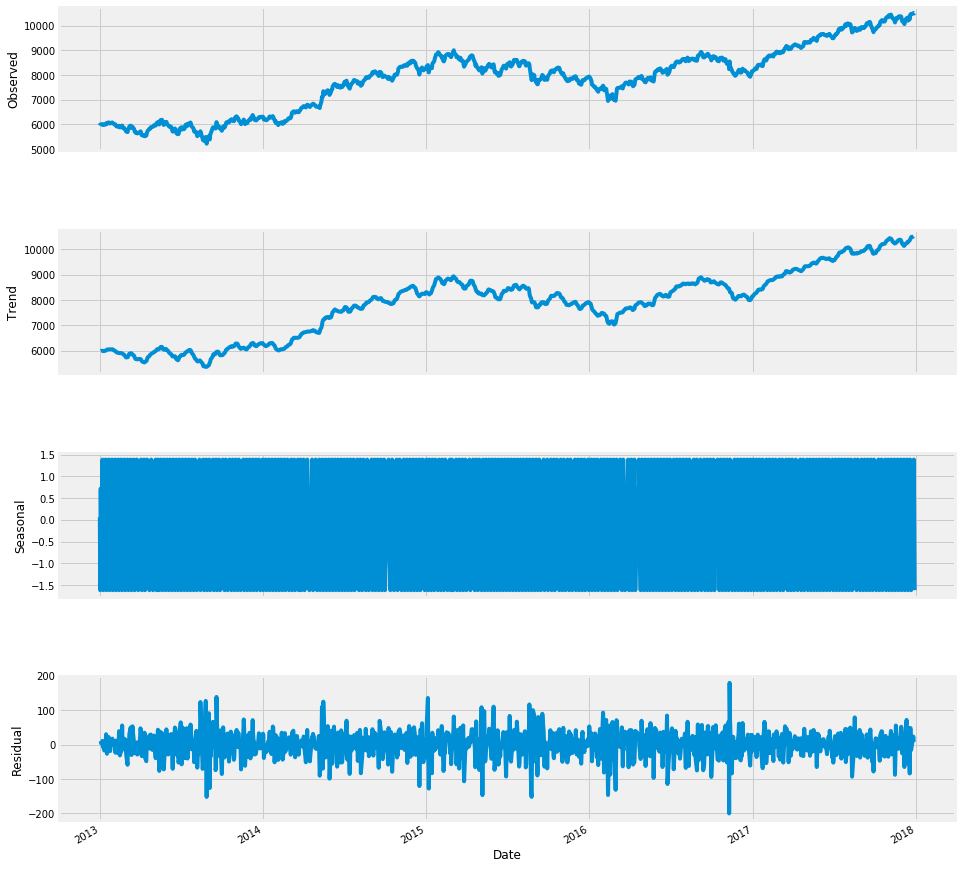

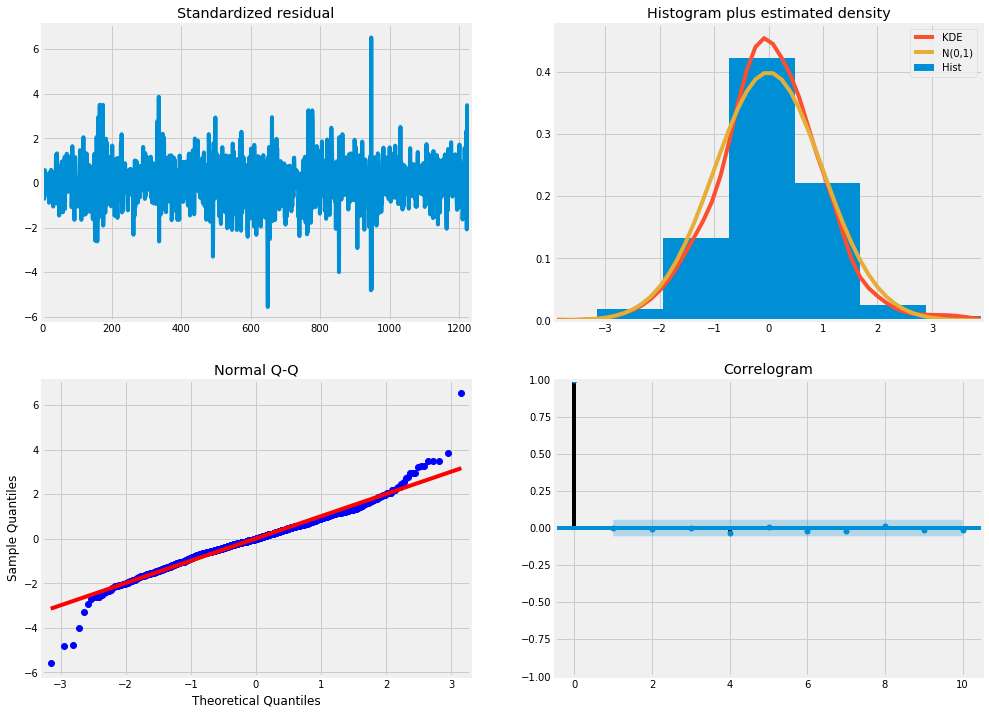

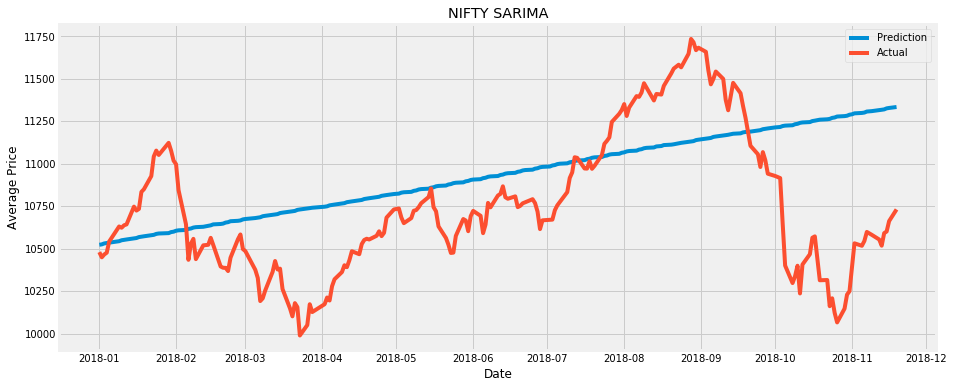

RMSE: 433.5275246569258
MAPE: 3.2385394716378206


In [4]:
y = get_data('../ml-project-data/NIFTY_train.csv', 0).loc[: , "High":"Low"].mean(axis=1)
act = get_data('../ml-project-data/NIFTY_test.csv', 0).loc[: , "High":"Low"].mean(axis=1)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, freq=5)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 15)
fig.show()

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore")
min = 999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        for trend in ['n', 'c', 't', 'ct']:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, #Change to y when doing nifty
                                                trend=trend,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                dynamic=True)

                results = mod.fit()
                if results.aic < min and results.aic > 100:
                    print('Trend:{} - ARIMA{}x{} - AIC:{}'.format(trend, param, param_seasonal, results.aic))
                    min = results.aic
                    trend_min = trend
                    param_min = param
                    param_seasonal_min = param_seasonal
            except:
                continue

mod = sm.tsa.statespace.SARIMAX(y,
                                trend=trend_min,
                                order=param_min,
                                seasonal_order=param_seasonal_min)

results = mod.fit()

print(results.summary())

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Get forecast 500 steps ahead in future
pred = results.forecast(len(act))

title = 'NIFTY'
pred = pd.DataFrame(np.array(pred),index = act.index,columns=['Prediction'])
plt.figure(figsize=(14,6))
plt.plot(pred, label="Prediction")
plt.plot(act, label="Actual")
plt.ylabel("Average Price")
plt.xlabel('Date')
plt.title(title + " SARIMA")
plt.legend(loc="best")
plt.show()

rms = sqrt(mean_squared_error(act, pred))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((act.values - pred['Prediction'].values) / act.values)) * 100
print('MAPE: ' + str(mape))

In [8]:
def company_wo_nifty(train_path, test_path, title):
    tcs_y = get_data(train_path, 2)['Average Price']
    tcs_act = get_data(test_path, 2)['Average Price']

    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(tcs_y, freq=5)
    fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 15)
    fig.show()

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]

    warnings.filterwarnings("ignore")
    min = 999999
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            for trend in ['n', 'c', 't', 'ct']:
                try:
                    mod = sm.tsa.statespace.SARIMAX(tcs_y, #Change to y when doing nifty
                                                    trend=trend,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    dynamic=True)

                    results = mod.fit()
                    if results.aic < min and results.aic > 100:
                        print('Trend:{} - ARIMA{}x{} - AIC:{}'.format(trend, param, param_seasonal, results.aic))
                        min = results.aic
                        trend_min = trend
                        param_min = param
                        param_seasonal_min = param_seasonal
                except:
                    continue

    tcs_mod = sm.tsa.statespace.SARIMAX(tcs_y,
                                    trend=trend,
                                    order=param_min,
                                    seasonal_order=param_seasonal)

    tcs_results = tcs_mod.fit()
    print(tcs_results.summary())

    tcs_results.plot_diagnostics(figsize=(15, 12))
    plt.show()

    # Get forecast 500 steps ahead in future
    tcs_pred = tcs_results.forecast(len(tcs_act))

    tcs_pred = pd.DataFrame(np.array(tcs_pred),index = tcs_act.index,columns=['Prediction'])
    plt.figure(figsize=(14,6))
    plt.plot(tcs_pred, label="Prediction")
    plt.plot(tcs_act, label="Actual")
    plt.ylabel("Average Price")
    plt.xlabel('Date')
    plt.title(title + " SARIMA")
    plt.legend(loc="best")
    plt.show()

    tcs_rms = sqrt(mean_squared_error(tcs_act, tcs_pred))
    print('RMSE: ' + str(tcs_rms))

    tcs_mape = np.mean(np.abs((tcs_act.values - tcs_pred['Prediction'].values) / tcs_act.values)) * 100
    print('MAPE: ' + str(tcs_mape))

Trend:n - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:22689.765761486342
Trend:c - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:18058.46864995932
Trend:ct - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:17289.807117399396
Trend:c - ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC:16716.032127396626
Trend:ct - ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC:16052.919959578461
Trend:n - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:14063.868734666723
Trend:c - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:14058.693176667606
Trend:ct - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:14055.453152716007
Trend:c - ARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC:14049.635584590109
Trend:ct - ARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC:14044.935839303693
Trend:n - ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC:14043.073949462756
Trend:c - ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC:14029.874095730236
Trend:n - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:11865.738128211096
Trend:n - ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC:11848.705884874988
Trend:n - ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC:11830.477950356915
Trend:n - ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC:11814.03

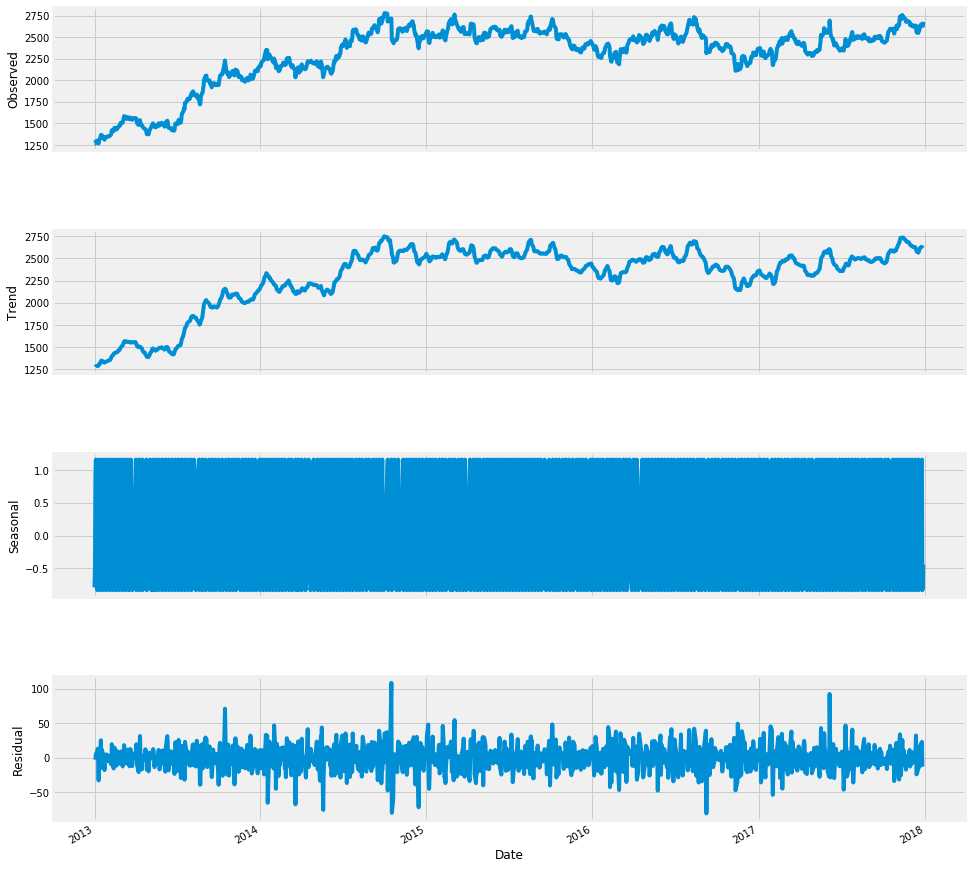

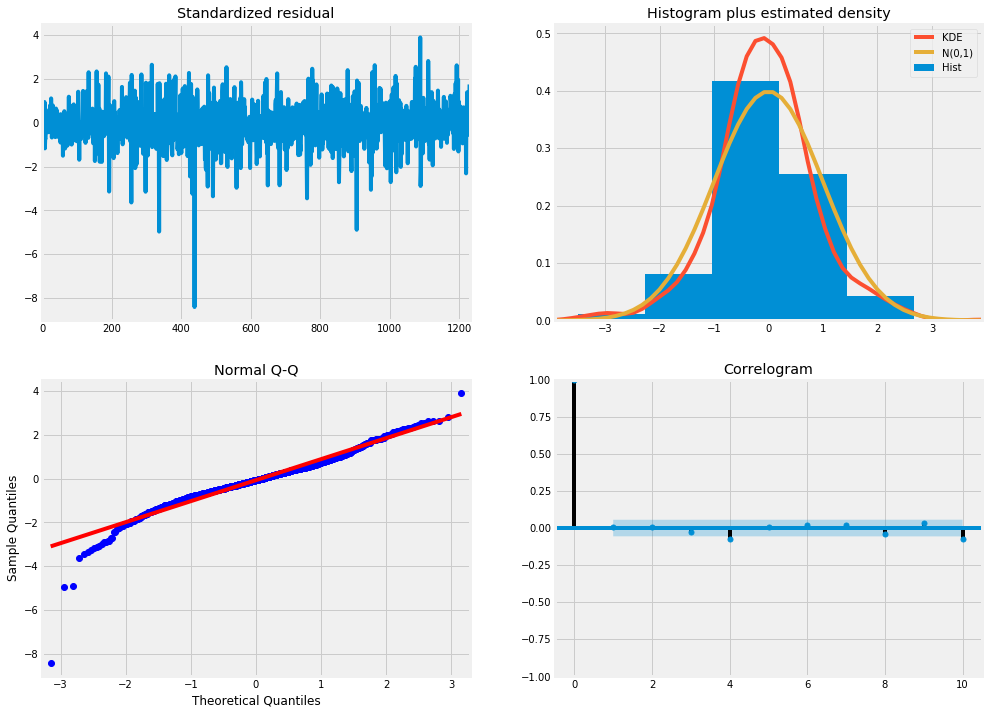

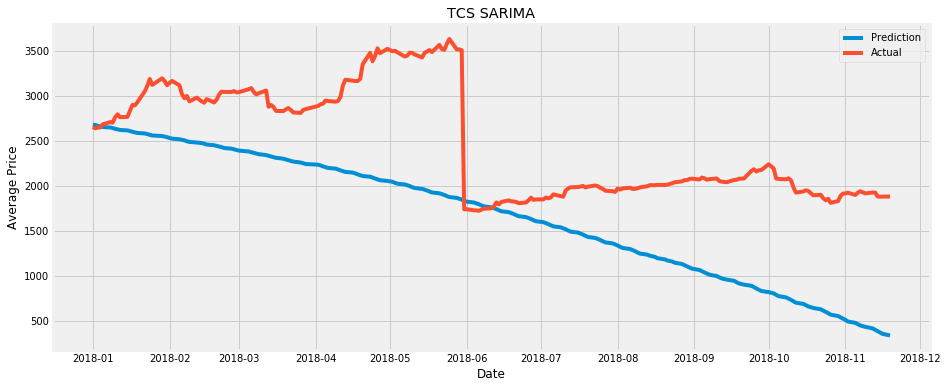

RMSE: 945.9717331125928
MAPE: 33.63194540767255


In [9]:
company_wo_nifty('../ml-project-data/TCS_train.csv', '../ml-project-data/TCS_test.csv', 'TCS')

Trend:n - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:22587.40482184849
Trend:c - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:20712.235141762623
Trend:ct - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:19329.042027138406
Trend:n - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:16261.539414247756
Trend:n - ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC:15484.446396830359
Trend:n - ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC:15458.7677877709
Trend:t - ARIMA(0, 0, 1)x(1, 1, 1, 5) - AIC:15458.703291549939
Trend:n - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:14277.948036125817
Trend:n - ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC:14252.184295200452
                                 Statespace Model Results                                
Dep. Variable:                     Average Price   No. Observations:                 1237
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 5)   Log Likelihood               -7137.994
Date:                           Mon, 10 Dec 2018   AIC                          14285.987
Time:                                   03:31:06   BIC                     

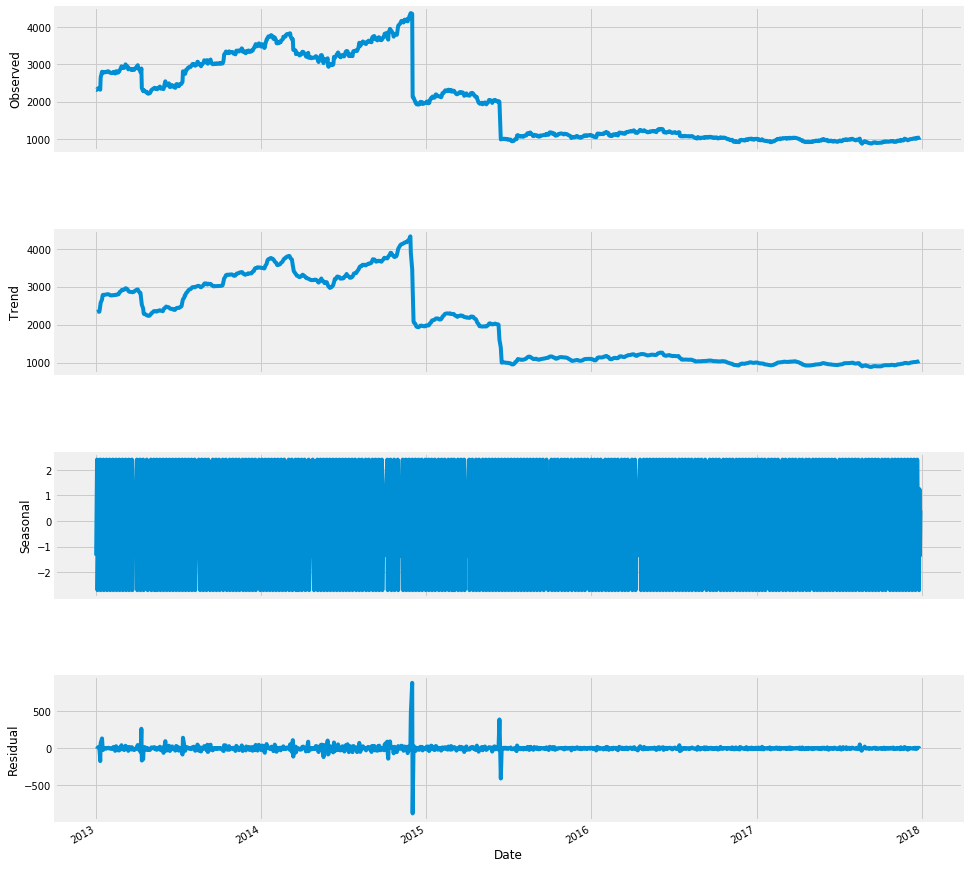

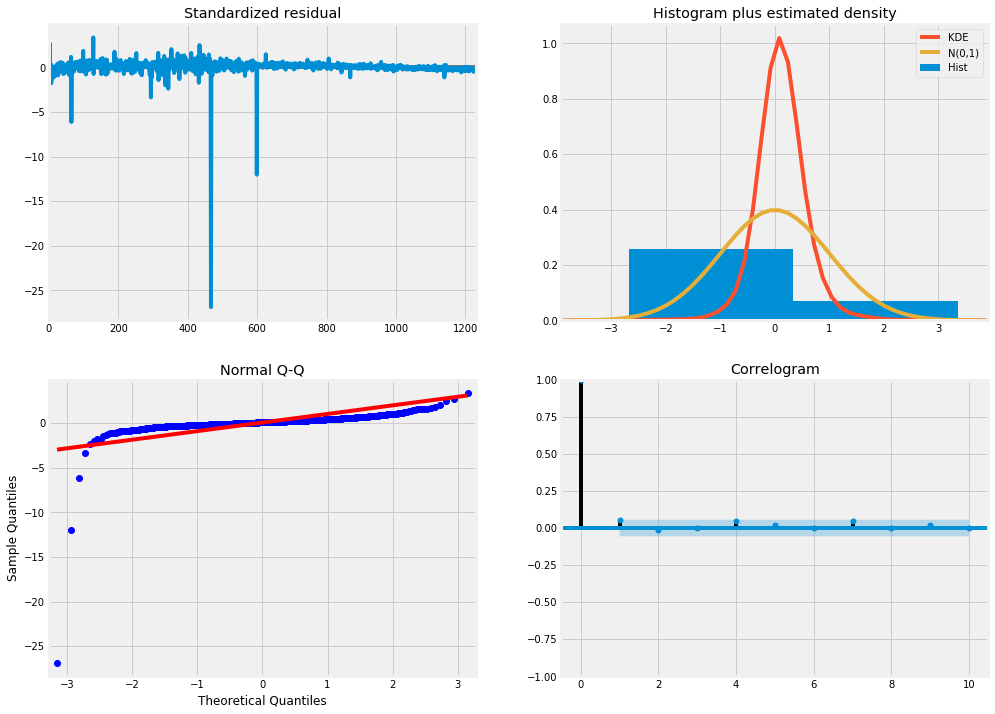

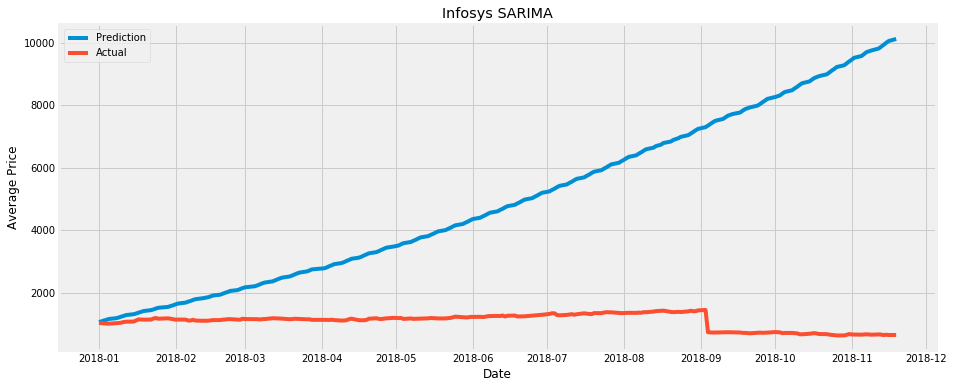

RMSE: 4716.794452598775
MAPE: 421.6301079069972


In [10]:
company_wo_nifty('../ml-project-data/INFY_train.csv', '../ml-project-data/INFY_test.csv', 'Infosys')

Trend:n - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:20789.15394765453
Trend:c - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:17836.710295042183
Trend:ct - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:17705.975619095952
Trend:n - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:14281.335657428586
Trend:n - ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC:13475.123354324109
Trend:n - ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC:13443.828942022119
Trend:n - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:12229.451450782803
Trend:n - ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC:12212.119650961075
Trend:n - ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC:12207.67098381599
                                 Statespace Model Results                                
Dep. Variable:                     Average Price   No. Observations:                 1237
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 5)   Log Likelihood               -6100.259
Date:                           Mon, 10 Dec 2018   AIC                          12212.518
Time:                                   03:33:45   BIC                    

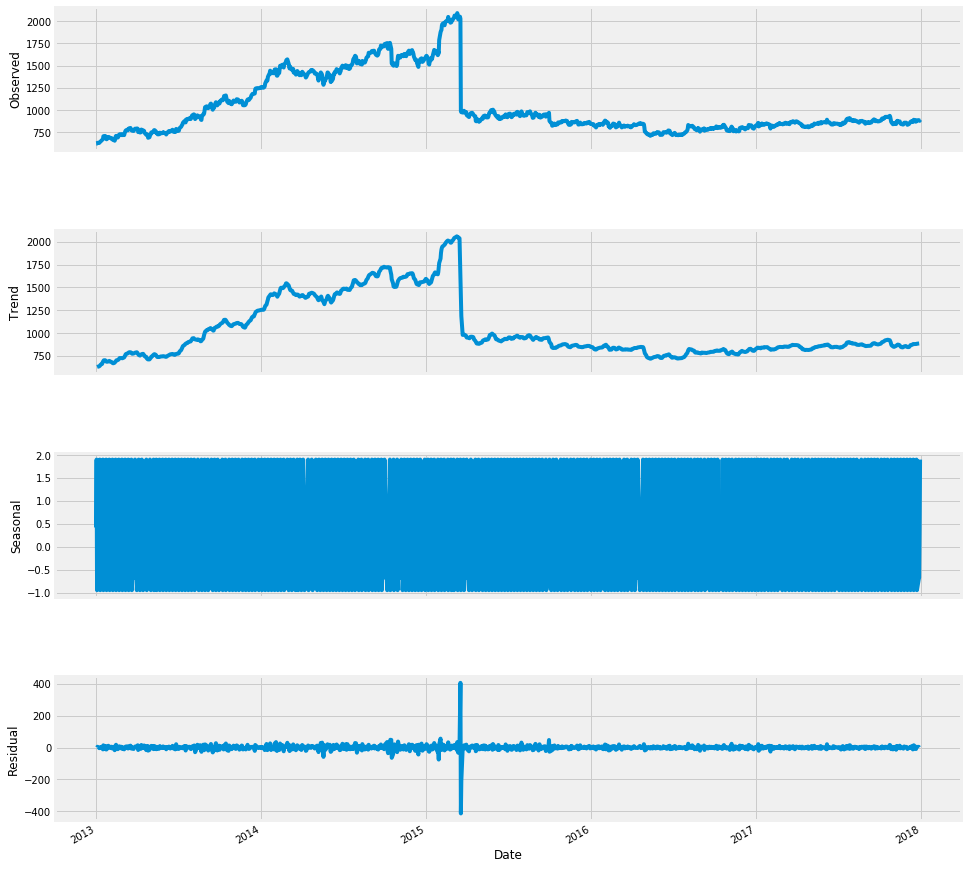

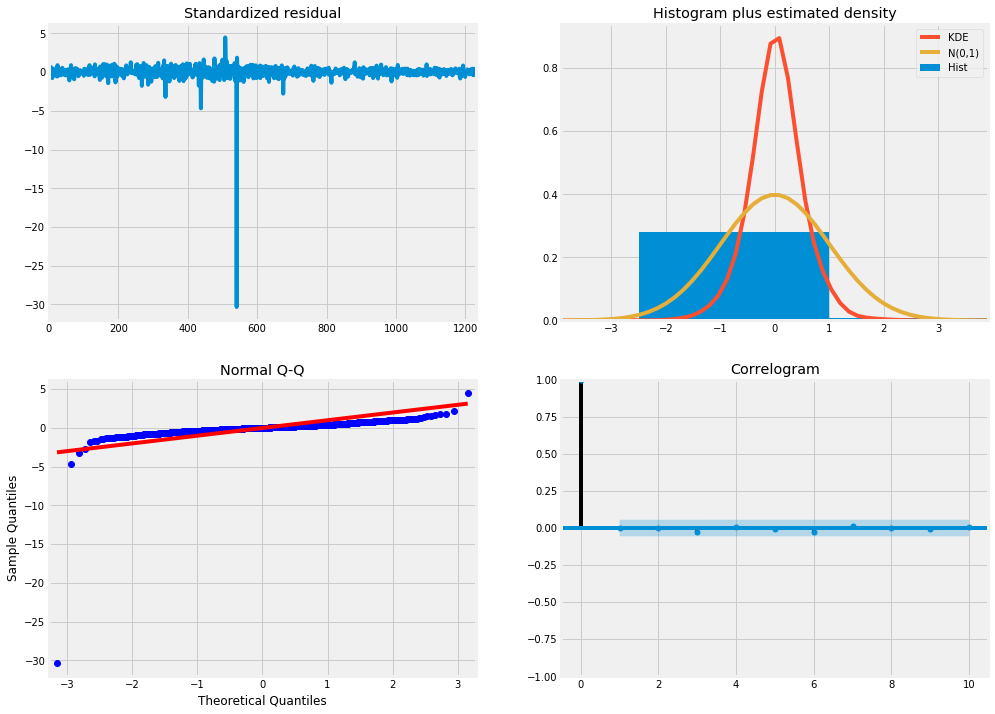

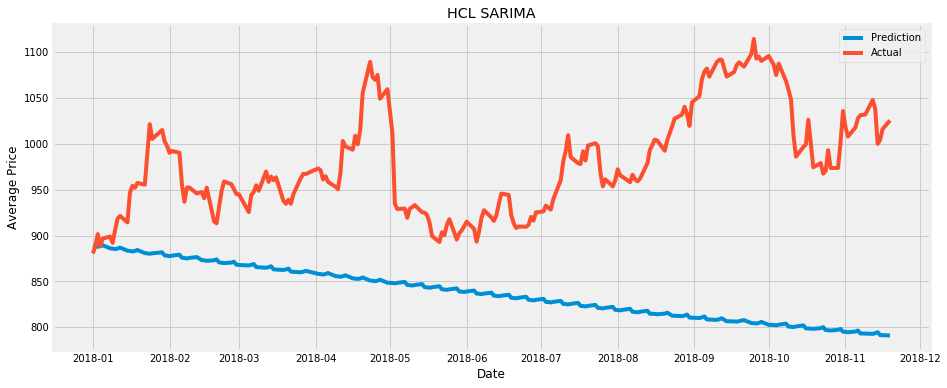

RMSE: 158.53918494577724
MAPE: 13.906386560433429


In [11]:
company_wo_nifty('../ml-project-data/HCL_train.csv', '../ml-project-data/HCL_test.csv', 'HCL')

Trend:n - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:21254.109546713866
Trend:c - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:19920.701029805005
Trend:ct - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:19401.735363522697
Trend:n - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:15785.822862205636
Trend:n - ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC:15006.258967336558
Trend:n - ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC:14978.4703114976
Trend:n - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:13779.690359621165
Trend:n - ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC:13755.526239748673
Trend:n - ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC:13755.441037448221
                                 Statespace Model Results                                
Dep. Variable:                     Average Price   No. Observations:                 1237
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 5)   Log Likelihood               -6929.188
Date:                           Mon, 10 Dec 2018   AIC                          13870.377
Time:                                   03:41:21   BIC                    

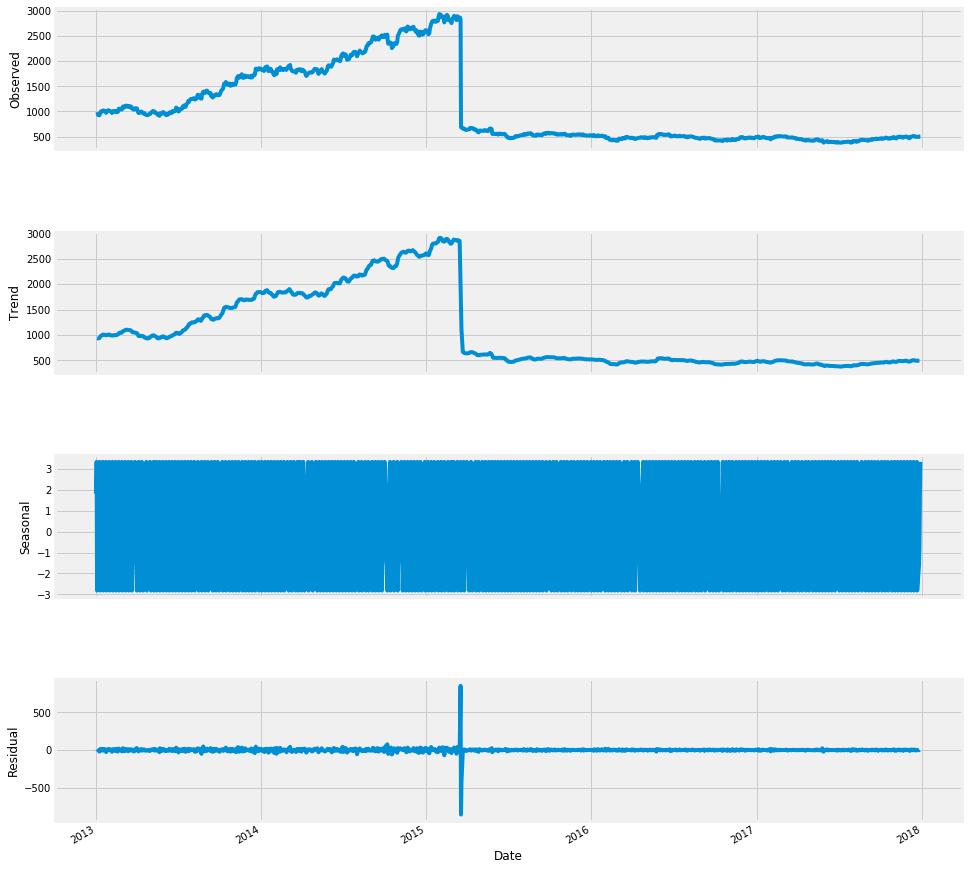

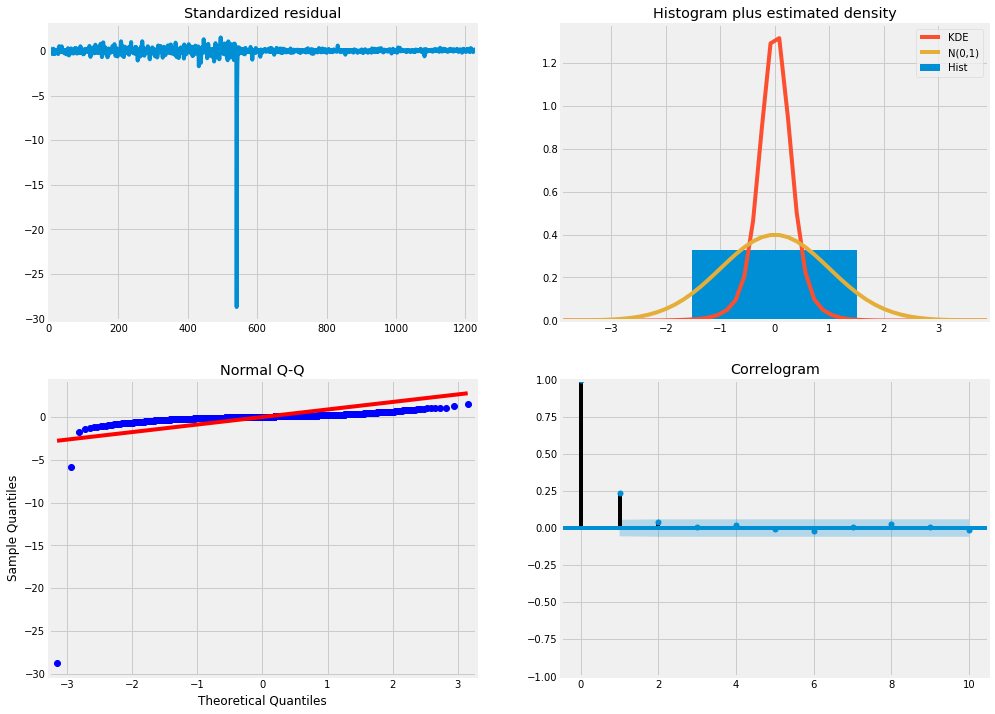

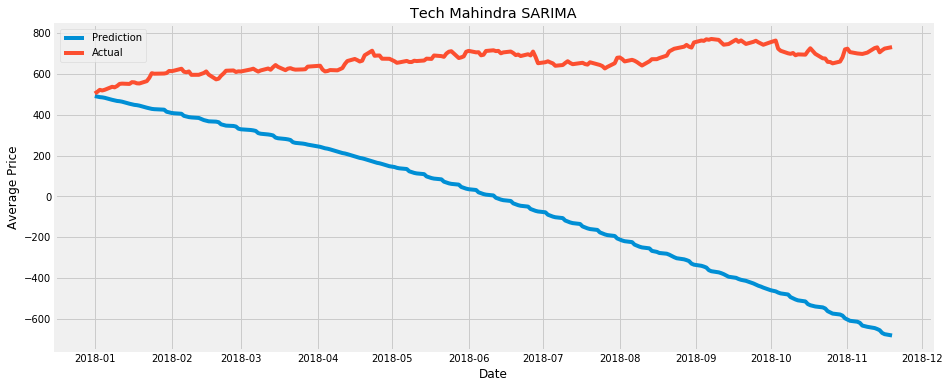

RMSE: 792.0110961669409
MAPE: 100.66066113767653


In [14]:
company_wo_nifty('../ml-project-data/TECHM_train.csv', '../ml-project-data/TECHM_test.csv', 'Tech Mahindra')

Trend:n - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:18894.06803284041
Trend:c - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:14851.802019867553
Trend:ct - ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC:14794.657666220584
Trend:n - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:11322.04031072538
Trend:t - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:11320.319917504006
Trend:ct - ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC:11317.317714908397
Trend:n - ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC:10494.649418396408
Trend:t - ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC:10494.009795453316
Trend:ct - ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC:10492.488711577256
Trend:n - ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC:10462.129957016532
Trend:t - ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC:10460.134639323125
Trend:ct - ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC:10456.979007015221
Trend:n - ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC:9193.951392762061
Trend:n - ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC:9186.494713152271
Trend:n - ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC:9179.429284233096
                                 Statespace Model Result

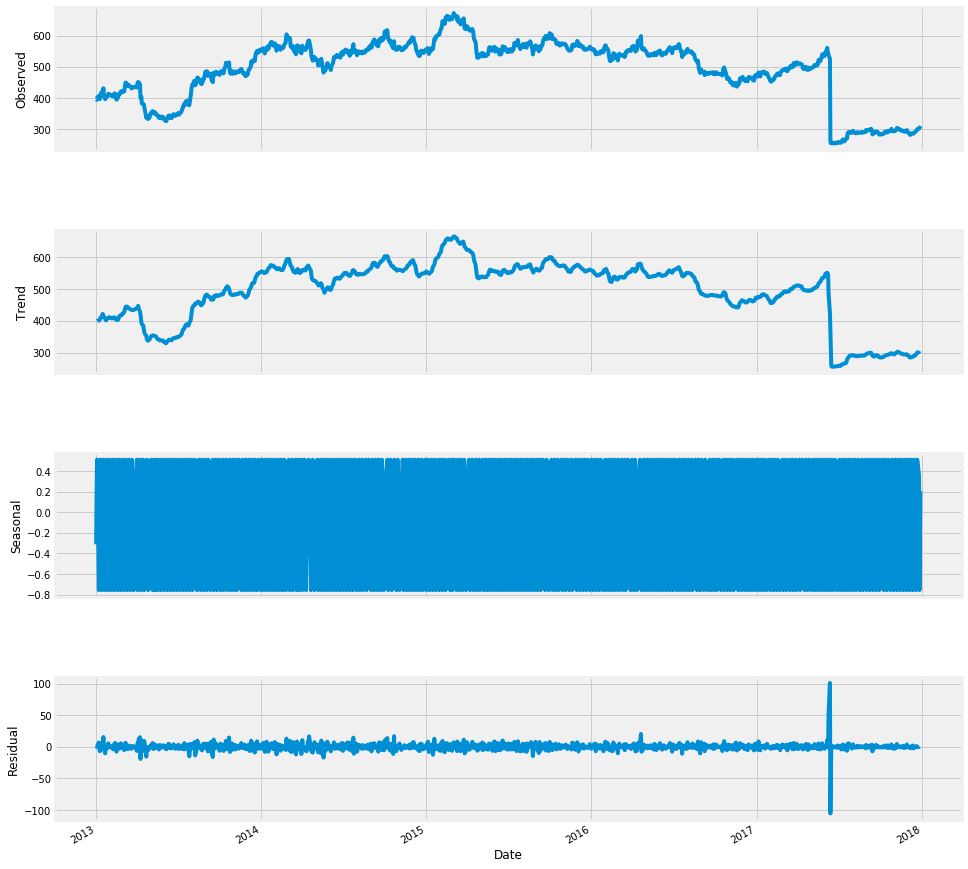

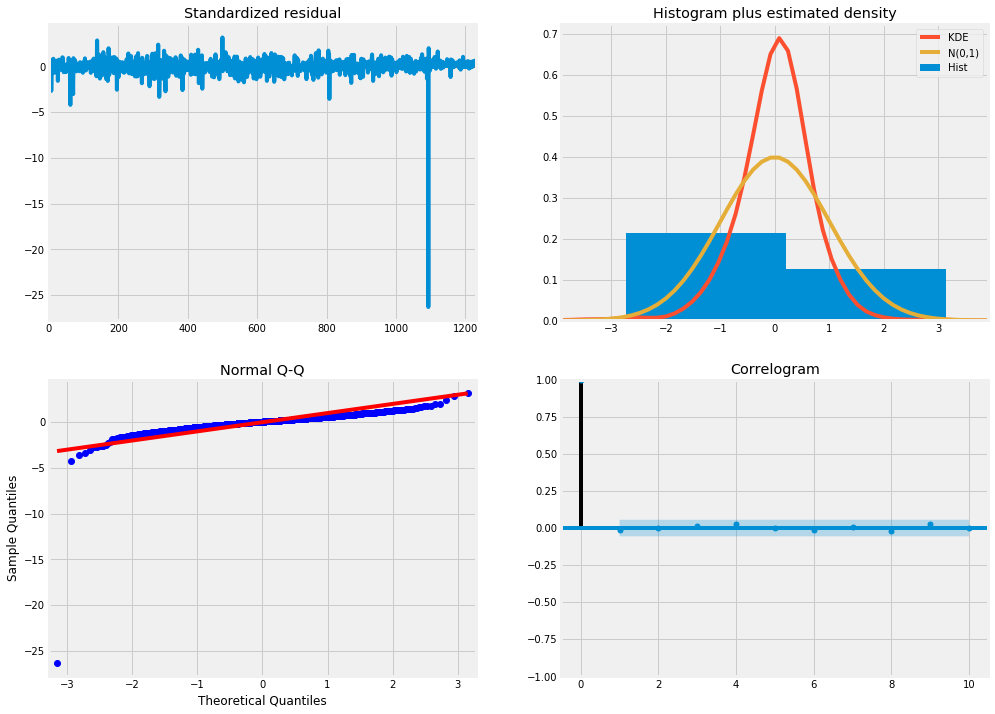

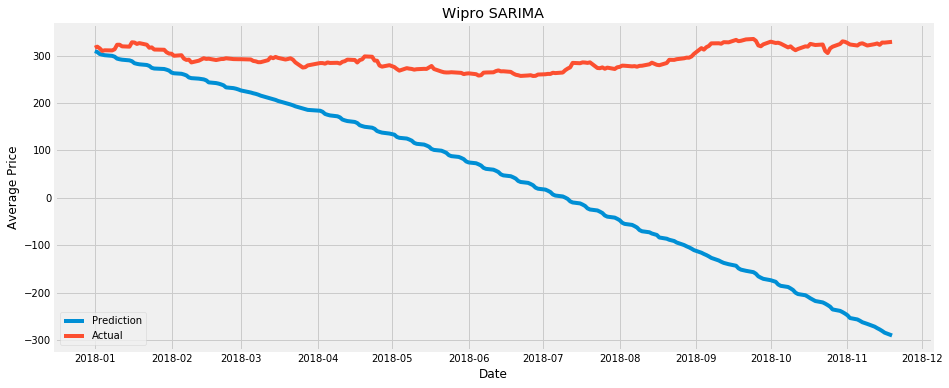

RMSE: 309.2382668766522
MAPE: 83.94840932115724


In [13]:
company_wo_nifty('../ml-project-data/WIPRO_train.csv', '../ml-project-data/WIPRO_test.csv', 'Wipro')